import

In [2]:
# for loading/processing the images  
from tensorflow.keras.utils import img_to_array, load_img
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

2023-04-25 10:57:34.901071: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 10:57:36.642898: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


***

In [5]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    img = img.reshape(1,224,224,3) 
    # prepare image for model
    x = preprocess_input(img)
    # get the feature vector
    features = model.predict(x, use_multiprocessing=True)
    return features

In [6]:
# load the model first and pass as an argument
model = VGG16()

# remove the output layer. 
# This means that the new final layer is a fully-connected layer with 4,096 output nodes. 
# This vector of 4,096 numbers is the feature vector that we will use to cluster the images.
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

path = "../data/images/0000000000_1.400.jpg"
extract_features(path, model)

2023-04-25 10:57:53.760121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4018 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:61:00.0, compute capability: 7.5
2023-04-25 10:57:58.894779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-25 10:58:00.003321: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-25 10:58:00.005592: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-25 10:58:00.005641: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-25 10:58:00.007854: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child pro

1/1 [==============================] - 3s 3s/step


array([[0.       , 0.68762  , 2.0652096, ..., 6.475277 , 0.       ,
        0.       ]], dtype=float32)

In [7]:
p = r"../data/images/"
flowers = []
with os.scandir(p) as files:
    for file in files:
        if file.name.endswith('.jpg'):
            flowers.append(file.name)

In [ ]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
data = {}
for i,flower in enumerate(flowers):
    path = p+str(flower)
    feat = extract_features(path, model);
    data[flower] = feat;

1/1 [==============================] - 0s 30ms/step


In [ ]:
# import pickle

# with open('my_dict.pckl', 'wb') as f:
#     pickle.dump(data, f)

In [4]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

NameError: name 'data' is not defined

In [72]:
# reshape so that there are x samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(128, 4096)

REDUCTION DIMENSION

In [74]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

CLUSTERING

In [97]:
kmeans = KMeans(n_clusters=8, random_state=22)
kmeans.fit(x)

/home/thomas.guerin@Digital-Grenoble.local/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(random_state=22)

In [98]:
kmeans.labels_

array([0, 4, 2, 5, 5, 1, 1, 7, 7, 3, 1, 7, 5, 3, 2, 1, 3, 7, 1, 2, 5, 1,
       1, 7, 3, 1, 1, 1, 2, 3, 1, 1, 2, 1, 4, 1, 7, 1, 1, 1, 4, 1, 7, 2,
       1, 5, 5, 5, 2, 2, 5, 4, 3, 3, 7, 6, 2, 5, 4, 7, 7, 7, 3, 7, 7, 3,
       2, 1, 1, 2, 0, 5, 1, 2, 1, 3, 1, 2, 5, 2, 5, 7, 7, 5, 3, 5, 1, 4,
       1, 3, 1, 1, 7, 3, 2, 1, 5, 6, 4, 1, 1, 7, 2, 3, 7, 1, 2, 3, 3, 1,
       2, 1, 2, 1, 5, 0, 2, 5, 7, 2, 1, 2, 4, 7, 2, 1, 7, 3], dtype=int32)

In [99]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [100]:
print(f"sur {len(data)} images analysées.")
print(f"il y a {len(groups)} clusters.\n")

for i in range(len(groups)):
    print(f"Nb images dans le {i}eme cluster : {len(groups[i])}")

sur 128 images analysées.
il y a 8 clusters.

Nb images dans le 0eme cluster : 3
Nb images dans le 1eme cluster : 37
Nb images dans le 2eme cluster : 23
Nb images dans le 3eme cluster : 17
Nb images dans le 4eme cluster : 8
Nb images dans le 5eme cluster : 17
Nb images dans le 6eme cluster : 2
Nb images dans le 7eme cluster : 21


Text(0, 0.5, 'PCA 2')

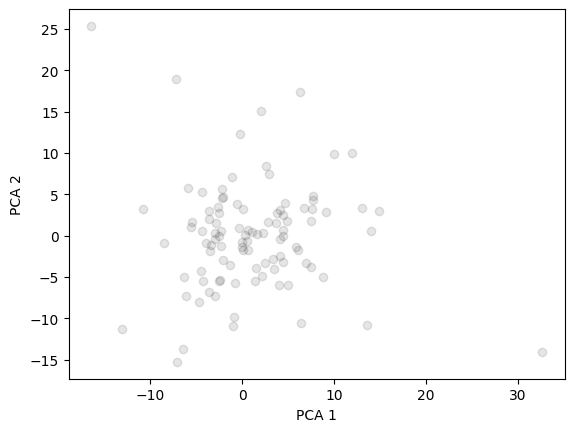

In [101]:
plt.scatter(x[0], x[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

***